In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely as sp
import fiona
import pyproj as pp
import six as six
import geopandas as gpd
import seaborn as sns
import rtree as rt
from shapely import wkt
import functools
import nltk
import requests

from matplotlib import pyplot as plt
from urllib.request import urlopen
from plotly import graph_objects as go
from plotly import express as px
from sklearn.feature_extraction.text import CountVectorizer
from geopy.distance import geodesic

import os

plt.style.use('fivethirtyeight')

### Importing Data, cleaning, and quick mapping

#### We have data courtesy of api scrapers from http://insideairbnb.com/get-the-data.html for our Chicago Airbnb data and Chicago neighborhood info via the City of Chicago's data portal. The Airbnb data especially is cumbersome and in need of scrubing for our purposes.

In [4]:
air = pd.read_csv('/Users/jonmale/Downloads/listings.csv')
hoods = pd.read_csv(r'Downloads/Neighborhoods_2012b.csv')

print(f"Number of listings: {air.count()[0]}")


Number of listings: 8533


/Users/jonmale/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
air.drop(columns=['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                  'maximum_nights_avg_ntm','security_deposit','cleaning_fee','guests_included','extra_people',
                  'minimum_nights','maximum_nights','reviews_per_month','first_review','review_scores_rating','property_type','is_location_exact',
                  'host_neighbourhood','neighbourhood','accommodates','country_code','country','market',
                  'bed_type','amenities','square_feet','weekly_price','monthly_price','host_location',
                  'neighbourhood_group_cleansed','calendar_updated','has_availability','availability_90','calendar_last_scraped','last_scraped',
                  'requires_license','number_of_reviews_ltm','availability_60','availability_30','street','host_identity_verified','host_has_profile_pic','host_listings_count','host_total_listings_count',
                  'host_verifications','availability_365','review_scores_accuracy','review_scores_value',
                  'host_picture_url','host_is_superhost','host_response_rate','last_review','review_scores_cleanliness',
                  'review_scores_checkin','review_scores_communication','review_scores_location','host_thumbnail_url','calculated_host_listings_count_entire_homes',
                  'host_url','host_acceptance_rate','license','jurisdiction_names','require_guest_profile_picture','require_guest_phone_verification',
                  'calculated_host_listings_count','host_about','host_response_time','cancellation_policy','calculated_host_listings_count_shared_rooms',
                  'calculated_host_listings_count_private_rooms','thumbnail_url','medium_url','xl_picture_url','instant_bookable',
                  'is_business_travel_ready','access','interaction','house_rules','picture_url','listing_url','description',
                  'space','neighborhood_overview','name','host_name','summary','experiences_offered','notes','transit'])



,id,scrape_id,host_id,host_since,neighbourhood_cleansed,city,state,zipcode,smart_location,latitude,longitude,room_type,bathrooms,bedrooms,beds,price,number_of_reviews
0,2384,20191121092422,2613,2008-08-29,Hyde Park,Chicago,IL,60637,"Chicago, IL",41.78886,-87.58671,Private room,1.0,1.0,1.0,$50.00,176
1,4505,20191121092422,5775,2008-12-29,South Lawndale,Chicago,IL,60608,"Chicago, IL",41.85495,-87.69696,Entire home/apt,1.0,3.0,4.0,$117.00,390
2,7126,20191121092422,17928,2009-05-19,West Town,Chicago,IL,60622,"Chicago, IL",41.90289,-87.68182,Entire home/apt,1.0,1.0,1.0,$80.00,370
3,9811,20191121092422,33004,2009-08-21,Lincoln Park,Chicago,IL,60614,"Chicago, IL",41.91769,-87.63788,Entire home/apt,1.0,1.0,0.0,$150.00,49
4,10610,20191121092422,2140,2008-08-16,Hyde Park,Chicago,IL,60615,"Chicago, IL",41.79708,-87.59195,Private room,1.0,1.0,1.0,$35.00,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8528,40262251,20191121092422,2912333,2012-07-12,Near North Side,Chicago,IL,60610,"Chicago, IL",41.90812,-87.63619,Entire home/apt,2.5,3.0,3.0,$299.00,0
8529,40263536,20191121092422,50413447,2015-12-02,Ohare,Des Plaines,IL,60018,"Des Plaines, IL",42.00712,-87.93466,Private room,1.0,1.0,1.0,$42.00,0
8530,40264107,20191121092422,35065108,2015-06-05,Belmont Cragin,Chicago,IL,60634,"Chicago, IL",41.93642,-87.76947,Private room,1.0,1.0,1.0,$69.00,0
8531,40264148,20191121092422,50413447,2015-12-02,Ohare,Des Plaines,IL,60018,"Des Plaines, IL",42.00712,-87.93466,Private room,1.0,2.0,2.0,$72.00,0


#### Lots of useful stuff here: nieghborhoods, pricing, and geodata. Let's start with prices...

In [6]:
print(air['price'].dtypes)

object


#### Prices are objects which is not surprising but let's convert it to something a little more workable and see how the distribute and what neighborhoods average the highest prices

In [7]:
air['price']  = air['price'].str.replace('$', '')
air['price']  = air['price'].str.replace(',', '')

air['price'] = air['price'].astype('float')

/Users/jonmale/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



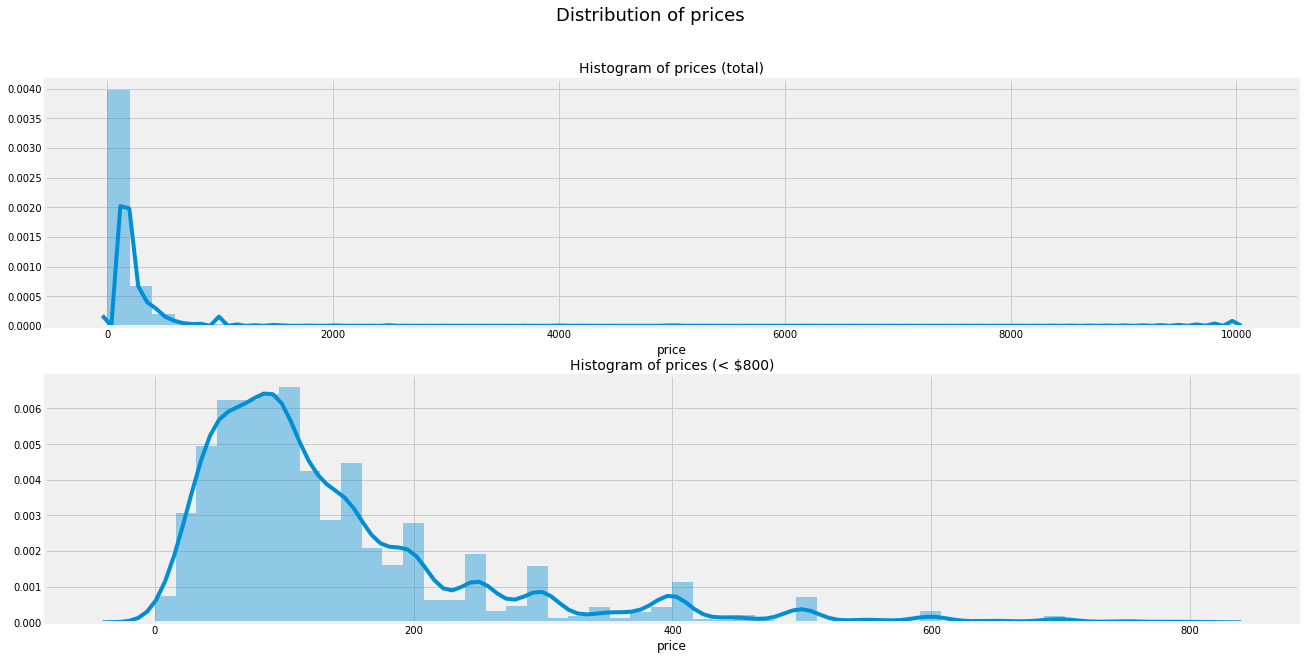

In [8]:
fig, ax= plt.subplots(2,1, figsize=(20,10))

ax[0].set_title("Histogram of prices (total)", size=14)
sns.distplot(air['price'], kde=True, ax=ax[0])
ax[1].set_title("Histogram of prices (< $800)", size=14)
sns.distplot(air[air['price'] < 800]['price'], kde=True, ax=ax[1])

fig.suptitle("Distribution of prices", size=18)
fig.show()


In [10]:
air.rename(columns={'neighbourhood_cleansed':'hood'}, inplace=True)


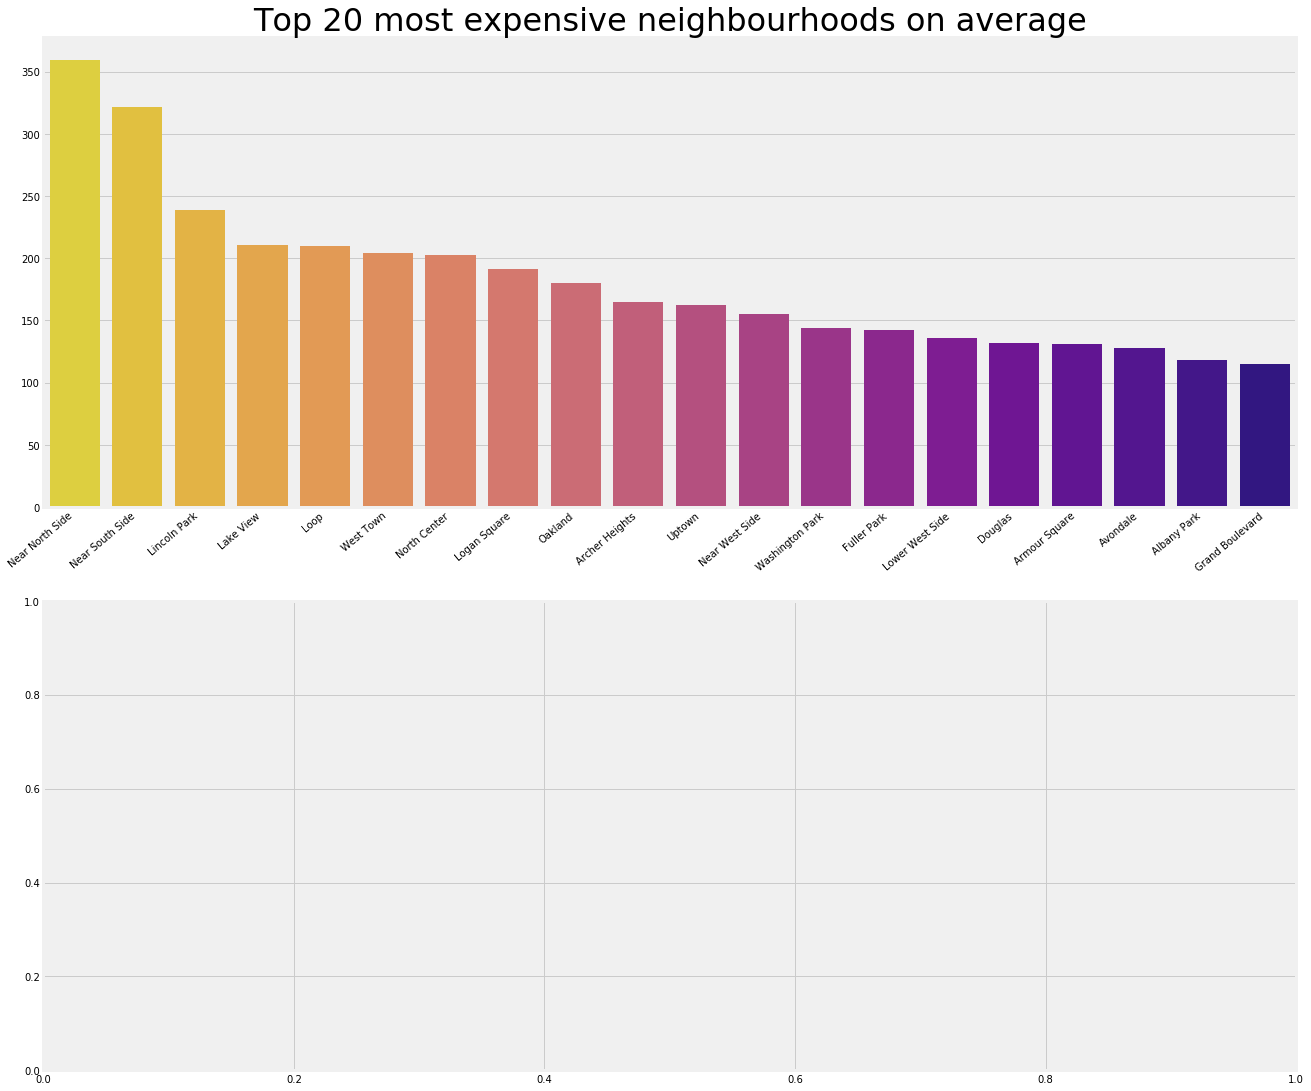

In [11]:
d = air.groupby('hood')['price'].mean().sort_values(ascending=False)

fig, ax= plt.subplots(2,1, figsize=(20,19))
sns.barplot(d.index.tolist()[:20], d.values[:20], ax=ax[0], palette=("plasma_r"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")

ax[0].set_title('Top 20 most expensive neighbourhoods on average', size=32)

plt.show()

### Let's do some quick models of Airbnb locations by neighborhood. The number of neighborhoods will probably make geo model a little clumsy

##### Unfortunately Chicago neighborhoods are not split into boroughs like NYC. The city contains 50 wards which are similar to neighborhood boundaries in some circumstances but not in others. 

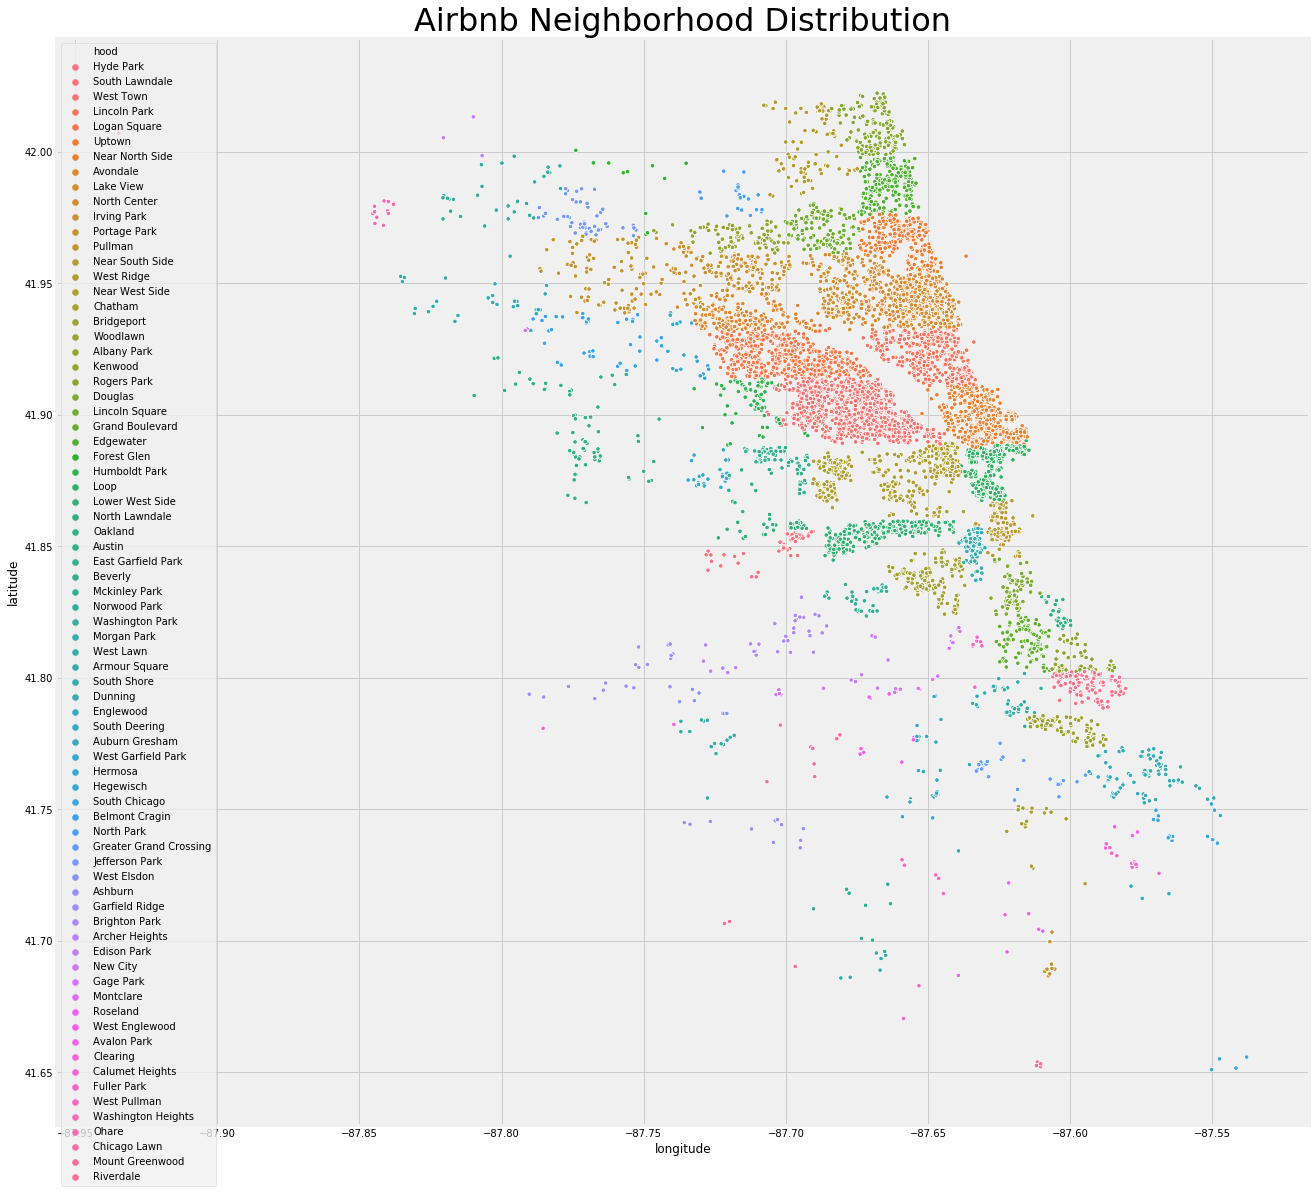

In [12]:
air.rename(columns={'neighbourhood_cleansed':'hood'}, inplace=True)

plt.figure(figsize=(20,20))
sns.scatterplot( y='latitude',x='longitude', hue='hood',s=20, data=air)

plt.title('Airbnb Neighborhood Distribution', size=32)

plt.show()

#### Let's take a peak at the neighborhood boundaries file.

##### Since the scatterplot is a bit clumsy, let's see if we can convert the lagitude and longitude columns to geopandas spacial points and fir them within the bounds of our map file. But first let's see how that neighborhood file from the City of Chicago looks... 

In [13]:
hoods.head(10)

,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60670812560372 41.81681377...,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157
1,MULTIPOLYGON (((-87.62760697485348 41.87437097...,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156
2,MULTIPOLYGON (((-87.66706868914602 41.88885187...,United Center,UNITED CENTER,3.252051e+07,23101.363745
3,MULTIPOLYGON (((-87.65833494805533 41.92166144...,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745
4,MULTIPOLYGON (((-87.74059567509266 41.88782316...,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351
5,MULTIPOLYGON (((-87.69540013130901 41.88818507...,Garfield Park,GARFIELD PARK,8.997607e+07,44460.919220
6,MULTIPOLYGON (((-87.72023936012896 41.86986908...,North Lawndale,NORTH LAWNDALE,8.948742e+07,44959.459663
7,MULTIPOLYGON (((-87.68739948177172 41.83480098...,Little Village,LITTLE VILLAGE,1.279983e+08,49904.040030
8,MULTIPOLYGON (((-87.62920071904188 41.84712706...,Armour Square,"ARMOUR SQUARE,CHINATOWN",1.714147e+07,24359.189625
9,MULTIPOLYGON (((-87.58565529833413 41.75150194...,Avalon Park,"AVALON PARK,CALUMET HEIGHTS",3.485274e+07,27630.822534


### Pretty straigh forward. Little confusing as which neighborhood column is better to work with but they both define the same area...

#### "Pri_neigh" is the column we probably want to work with in terms of diffinitive neighborhood names. Since these neighborhoods are unofficial, the "Sec_neigh" column seems to outline where any overlap. Let's rename and start transitioning everything to Geopandas.

In [14]:
hoods.rename(columns={'pri_neigh':'hood'}, inplace=True)

In [15]:
hoods['geom'] = hoods['the_geom'].apply(wkt.loads)

In [16]:
hoods = gpd.GeoDataFrame(hoods, geometry='geom')

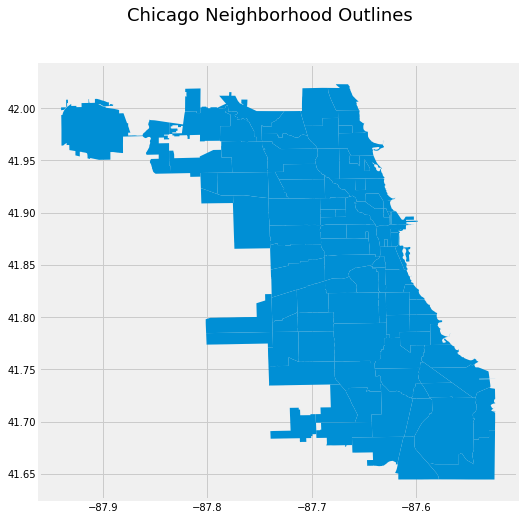

In [17]:
fig,ax = plt.subplots(1,1, figsize=(8,8))
hoods.plot(ax=ax)

fig.suptitle("Chicago Neighborhood Outlines", size=18)

plt.show()

#### Easy enough for the existing geometry in the CoC file, now let's cross our fingers and hope the latitude/longitude airbnb points convert 

In [18]:
air = gpd.GeoDataFrame(air, geometry=gpd.points_from_xy(air.longitude, air.latitude))

In [19]:
air_clean = air[air.geometry.type == 'Point']
hoods_clean =hoods[hoods.geometry.type == 'Polygon']
hoods_clean =hoods[hoods.geometry.type == 'MULTIPOLYGON']

hoods.head()

,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geom
0,MULTIPOLYGON (((-87.60670812560372 41.81681377...,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
1,MULTIPOLYGON (((-87.62760697485348 41.87437097...,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"MULTIPOLYGON (((-87.62761 41.87437, -87.62760 ..."
2,MULTIPOLYGON (((-87.66706868914602 41.88885187...,United Center,UNITED CENTER,3.252051e+07,23101.363745,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
3,MULTIPOLYGON (((-87.65833494805533 41.92166144...,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"MULTIPOLYGON (((-87.65833 41.92166, -87.65835 ..."
4,MULTIPOLYGON (((-87.74059567509266 41.88782316...,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"MULTIPOLYGON (((-87.74060 41.88782, -87.74060 ..."


#### Great both files converted, now lets join the files and clean a little again

In [20]:
joined = gpd.sjoin(air, hoods, how='inner', op='intersects')

In [21]:
joined.drop(columns=['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                  'maximum_nights_avg_ntm','security_deposit','cleaning_fee','guests_included','extra_people',
                  'minimum_nights','maximum_nights','reviews_per_month','first_review','review_scores_rating','is_location_exact',
                  'host_neighbourhood','neighbourhood','accommodates','country_code','country','market',
                  'bed_type','amenities','square_feet','weekly_price','monthly_price','host_location',
                  'neighbourhood_group_cleansed','calendar_updated','has_availability','availability_90','calendar_last_scraped','last_scraped',
                  'requires_license','number_of_reviews_ltm','availability_60','availability_30','street','host_identity_verified','host_has_profile_pic','host_listings_count','host_total_listings_count',
                  'host_verifications','availability_365','review_scores_accuracy','review_scores_value',
                  'host_picture_url','host_is_superhost','host_response_rate','last_review','review_scores_cleanliness',
                  'review_scores_checkin','review_scores_communication','review_scores_location','host_thumbnail_url','calculated_host_listings_count_entire_homes',
                  'host_url','host_acceptance_rate','license','jurisdiction_names','require_guest_profile_picture','require_guest_phone_verification',
                  'calculated_host_listings_count','host_about','host_response_time','cancellation_policy','calculated_host_listings_count_shared_rooms',
                  'calculated_host_listings_count_private_rooms','thumbnail_url','medium_url','xl_picture_url','instant_bookable',
                  'is_business_travel_ready','access','interaction','house_rules','picture_url','listing_url','description',
                  'space','neighborhood_overview','name','host_name','summary','experiences_offered','notes','transit'])

joined.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN
0,2384,https://www.airbnb.com/rooms/2384,20191121092422,2019-11-21,"Walk to UChicago, 10 min train to McCormick Place",Visiting The University of Chicago or attendin...,"The private bedroom has a queen size bed, beds...",Visiting The University of Chicago or attendin...,none,My apartment is one block from beautiful Jacks...,...,1,0,2.97,POINT (-87.58671 41.78886),74,MULTIPOLYGON (((-87.57930134740258 41.79348709...,Hyde Park,HYDE PARK,3.885916e+07,28013.027919
4,10610,https://www.airbnb.com/rooms/10610,20191121092422,2019-11-21,3 Comforts of Cooperative Living,The condo is the 2nd floor in a lovely 1912 3-...,Newly furnished with queen bed and the comfort...,The condo is the 2nd floor in a lovely 1912 3-...,none,It's a 10 minute walk from the lakefront bike ...,...,4,0,0.70,POINT (-87.59195 41.79708),74,MULTIPOLYGON (((-87.57930134740258 41.79348709...,Hyde Park,HYDE PARK,3.885916e+07,28013.027919
53,349265,https://www.airbnb.com/rooms/349265,20191121092422,2019-11-21,Historic Chicago Home - Hyde Park,"Steps away from fine dining, theater, Whole Fo...",Rent a spacious historic home in the Universi...,"Steps away from fine dining, theater, Whole Fo...",none,Hyde Park is home,...,0,0,0.09,POINT (-87.58948 41.80086),74,MULTIPOLYGON (((-87.57930134740258 41.79348709...,Hyde Park,HYDE PARK,3.885916e+07,28013.027919
173,1526309,https://www.airbnb.com/rooms/1526309,20191121092422,2019-11-21,Private Sunny Hyde Park Room & Bath,"Hello! My wife and I are renting a sunny, pri...","Our house features two floors, large airy room...","Hello! My wife and I are renting a sunny, pri...",none,NaN,...,1,0,1.94,POINT (-87.59601 41.79819),74,MULTIPOLYGON (((-87.57930134740258 41.79348709...,Hyde Park,HYDE PARK,3.885916e+07,28013.027919
196,1746734,https://www.airbnb.com/rooms/1746734,20191121092422,2019-11-21,Stylish One Bedroom Apt In HydePark,My one bedroom apartment is comfortable and sp...,My apartment is truly a gem of the city and Hy...,My one bedroom apartment is comfortable and sp...,none,"I absolutely adore my neighborhood, and while ...",...,0,0,4.41,POINT (-87.59465 41.79984),74,MULTIPOLYGON (((-87.57930134740258 41.79348709...,Hyde Park,HYDE PARK,3.885916e+07,28013.027919


#### Looking good! We have points and figures to fit those points into! Let's count, merge, and map

In [22]:
nb_join_count = joined.groupby('PRI_NEIGH').agg('count').reset_index()

In [23]:
true_count = hoods.merge(nb_join_count, on='PRI_NEIGH')

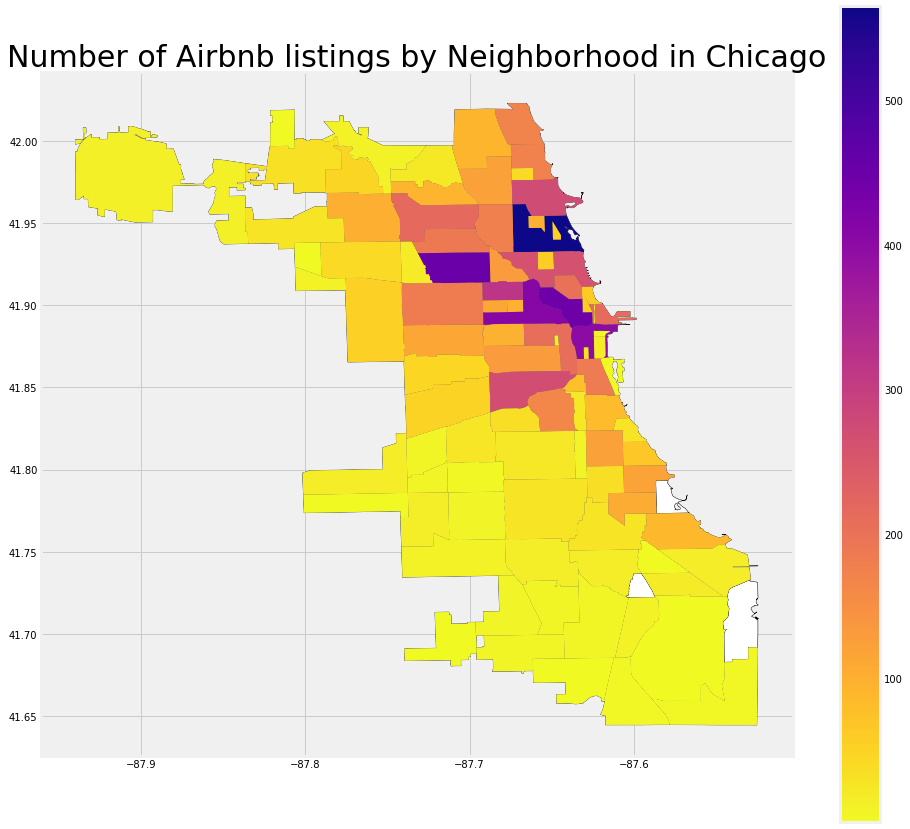

In [24]:
fig,ax = plt.subplots(1,1, figsize=(15,15))

base = hoods.plot(color='white', edgecolor='black', ax=ax)

true_count.plot(column='id',cmap='plasma_r', ax=base, legend=True)

plt.title("Number of Airbnb listings by Neighborhood in Chicago",size=30)

plt.show()

### Great! Let's see if we can get just a little more creative and add an interactive map via plotly ###

In [35]:
fig = px.scatter_mapbox(joined, lat="latitude", lon="longitude", hover_name="PRI_NEIGH", hover_data=["room_type", "price","hood"],
                        color="PRI_NEIGH", size="price", zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


